# Train Models Notebook

This notebook trains the different models that will be compared using the data from the ISIC 2017 challenge. The models that will be trained are:

- Unet (Baseline)
- Attention Unet
- R2Unet
- Attention R2Unet
- TransUnet

In [ ]:
# !pip install torch==2.3.0 torchaudio==2.3.0 torchvision==0.18.0
# !pip install albumentations numpy pandas scikit_learn kaggle
# !pip install resnest geffnet opencv-python pretrainedmodels tqdm Pillow packaging

In [ ]:
# pip install -i https://test.pypi.org/simple/ melanoma-segmentation==0.4

In [8]:
from configs.config_setting import CONFIG
from models.unet import UNet
# from models.attention_unet import AttUNet
from models.trans_unet import TransUNet
from results.plots import plot_img_mask_pred
from utils import prepare_datasets

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:

# Access the values like this:
base_dir = CONFIG["base_dir"]
image_folder = CONFIG["image_folder"]
gt_folder = CONFIG["gt_folder"]
model_name = CONFIG["model_name"]
split_train = CONFIG["split_train"]
split_val = CONFIG["split_val"]
split_test = CONFIG["split_test"]
image_size = CONFIG["image_size"]
batch_size = CONFIG["batch_size"]
model_path = CONFIG["model_path"]
device = CONFIG["device"]

In [3]:
# Recieve the image and ground truth paths
train_dataset, val_dataset, test_dataset = prepare_datasets(CONFIG, train_transform_type="train")

# Get the train test and validation dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Retrieving image and ground truth paths...


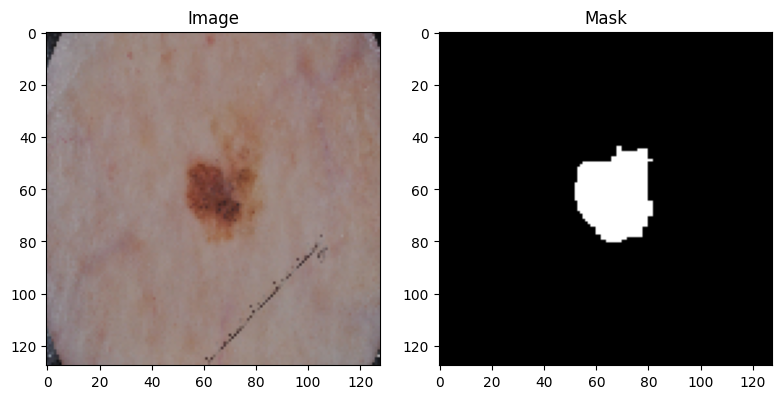

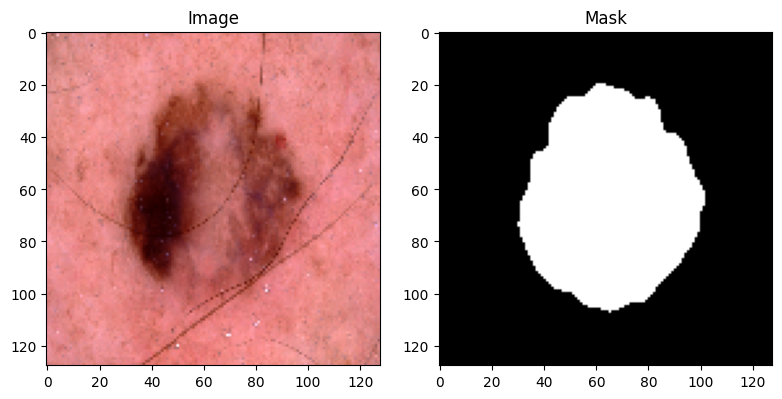

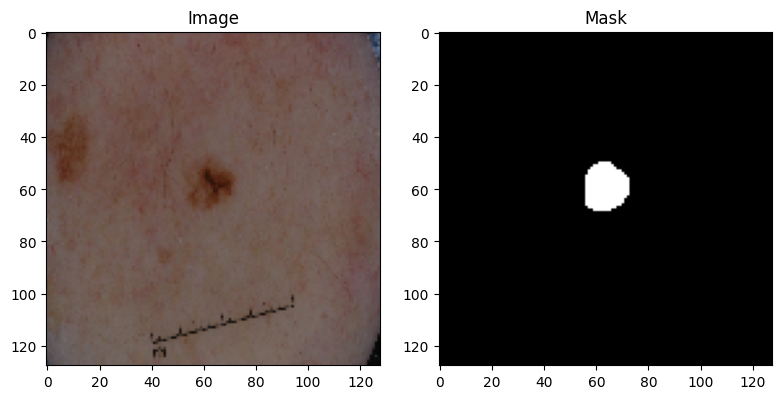

In [4]:
plot_img_mask_pred(train_dataset)
plot_img_mask_pred(val_dataset)
plot_img_mask_pred(test_dataset)


# Train Model

In [5]:
!nvidia-smi

Sat Oct 19 18:51:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:2B:00.0  On |                  N/A |
| 23%   36C    P8              9W /   75W |    1492MiB /   4096MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
model = UNet(3, 1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() >= 1:
    print("Using", torch.cuda.device_count(), "GPUs.")
    model = torch.nn.DataParallel(model)
    model.cuda()
# Check if the model is on the GPU



In [7]:
#Define Optimizer and Loss Function
import torch.optim as optim
import torch.nn as nn

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# Train the model
for epoch in range(10):
    model.train()
    for i, (images, masks) in enumerate(train_dataloader):
        images=images
        images = images.to(device)
        masks = masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(
                f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}"
            )

# Save the model
torch.save(model.state_dict(), "unet.pth")

torch.Size([16, 3, 128, 128])
torch.Size([16, 1, 128, 128])
Masks stats:  tensor(0.) tensor(1.) tensor(0.2393)
Outputs stats:  tensor(-4.9068, grad_fn=<MinBackward1>) tensor(1.6716, grad_fn=<MaxBackward1>) tensor(-0.1217, grad_fn=<MeanBackward0>)
Epoch: 0, Batch: 0, Loss: 0.7099000811576843
torch.Size([16, 3, 128, 128])
torch.Size([16, 1, 128, 128])
Masks stats:  tensor(0.) tensor(1.) tensor(0.2408)
Outputs stats:  tensor(-4.0647, grad_fn=<MinBackward1>) tensor(1.6023, grad_fn=<MaxBackward1>) tensor(-0.1265, grad_fn=<MeanBackward0>)
torch.Size([16, 3, 128, 128])
torch.Size([16, 1, 128, 128])
Masks stats:  tensor(0.) tensor(1.) tensor(0.1875)
Outputs stats:  tensor(-3.7437, grad_fn=<MinBackward1>) tensor(1.6771, grad_fn=<MaxBackward1>) tensor(-0.1278, grad_fn=<MeanBackward0>)
torch.Size([16, 3, 128, 128])
torch.Size([16, 1, 128, 128])
Masks stats:  tensor(0.) tensor(1.) tensor(0.1352)
Outputs stats:  tensor(-3.2908, grad_fn=<MinBackward1>) tensor(2.2276, grad_fn=<MaxBackward1>) tensor(-

KeyboardInterrupt: 

In [ ]:
model

In [ ]:
img_example = test_dataset[100]

result = model(img_example[0].unsqueeze(0).to(device))
print(result)
#Change every pixel to 1 if > 0 ans < 0
result = (result > 0).float()
print(result)

plt.imshow(result.squeeze().cpu().detach().numpy())
plt.show()

plt.imshow(img_example[1].squeeze().cpu().detach().numpy())
plt.show()